In [1]:
import itertools

from model import *
from data import *
import os
import matplotlib.pyplot as plt
from utils import plot_segm_history
import numpy as np
from keras.applications.vgg16 import VGG16

ModuleNotFoundError: No module named 'keras'

In [2]:
model = unet()
model.load_weights("unet3d.hdf5")
model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/thomas.bischof/src/asli.ergin/segmentation/unet_3channel/model.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [3]:
# summarize filter shapes
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d_1 (3, 3, 3, 64)
conv2d_2 (3, 3, 64, 64)
conv2d_3 (3, 3, 64, 128)
conv2d_4 (3, 3, 128, 128)
conv2d_5 (3, 3, 128, 256)
conv2d_6 (3, 3, 256, 256)
conv2d_7 (3, 3, 256, 512)
conv2d_8 (3, 3, 512, 512)
conv2d_9 (3, 3, 512, 1024)
conv2d_10 (3, 3, 1024, 1024)
conv2d_11 (2, 2, 1024, 512)
conv2d_12 (3, 3, 1024, 512)
conv2d_13 (3, 3, 512, 512)
conv2d_14 (2, 2, 512, 256)
conv2d_15 (3, 3, 512, 256)
conv2d_16 (3, 3, 256, 256)
conv2d_17 (2, 2, 256, 128)
conv2d_18 (3, 3, 256, 128)
conv2d_19 (3, 3, 128, 128)
conv2d_20 (2, 2, 128, 64)
conv2d_21 (3, 3, 128, 64)
conv2d_22 (3, 3, 64, 64)
conv2d_23 (3, 3, 64, 2)
conv2d_24 (1, 1, 2, 1)


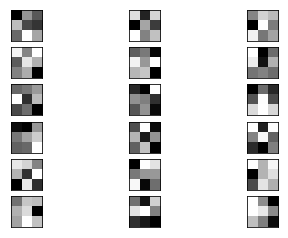

In [4]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [5]:
#now feature maps
# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

1 conv2d_1 (?, 256, 256, 64)
2 conv2d_2 (?, 256, 256, 64)
4 conv2d_3 (?, 128, 128, 128)
5 conv2d_4 (?, 128, 128, 128)
7 conv2d_5 (?, 64, 64, 256)
8 conv2d_6 (?, 64, 64, 256)
10 conv2d_7 (?, 32, 32, 512)
11 conv2d_8 (?, 32, 32, 512)
14 conv2d_9 (?, 16, 16, 1024)
15 conv2d_10 (?, 16, 16, 1024)
18 conv2d_11 (?, 32, 32, 512)
20 conv2d_12 (?, 32, 32, 512)
21 conv2d_13 (?, 32, 32, 512)
23 conv2d_14 (?, 64, 64, 256)
25 conv2d_15 (?, 64, 64, 256)
26 conv2d_16 (?, 64, 64, 256)
28 conv2d_17 (?, 128, 128, 128)
30 conv2d_18 (?, 128, 128, 128)
31 conv2d_19 (?, 128, 128, 128)
33 conv2d_20 (?, 256, 256, 64)
35 conv2d_21 (?, 256, 256, 64)
36 conv2d_22 (?, 256, 256, 64)
37 conv2d_23 (?, 256, 256, 2)
38 conv2d_24 (?, 256, 256, 1)


In [6]:
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [7]:
# load the image with the required shape
img = tf.keras.preprocessing.image.load_img('test_image.png', target_size=(256, 256))
# convert the image to an array
img = tf.keras.preprocessing.image.img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = tf.keras.applications.vgg16.preprocess_input(img)

In [8]:
feature_maps = model.predict(img)

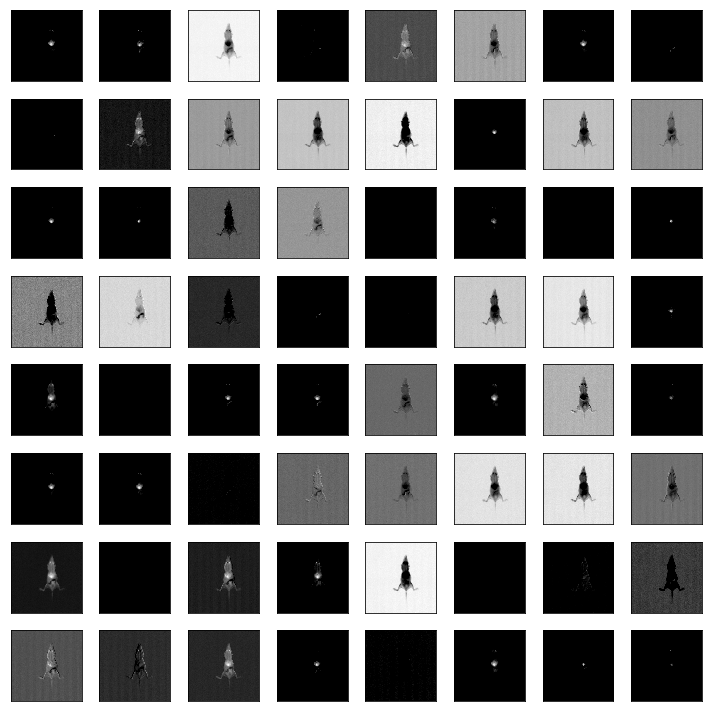

In [9]:
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
fig = plt.figure(figsize=(10,10))
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = fig.add_subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        ax.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
fig.tight_layout()
plt.show()

In [10]:
# redefine model to output after each block
model = unet()
model.load_weights("unet3d.hdf5")
model.summary()
for layer in model.layers:
    weights = layer.get_weights()
    print(weights)
    break
    




Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_25[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_26[0][0]                  
____________________________________________________________________________________________

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_49[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_50[0][0]                  
____________________________________________________________________________________________

Block 1


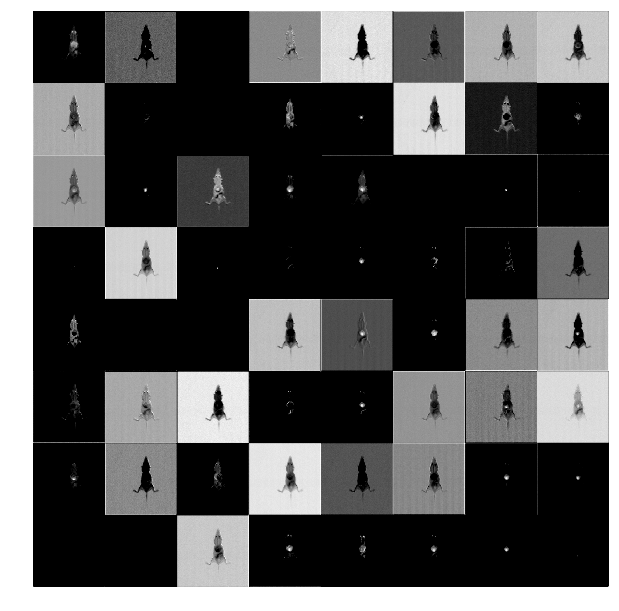

Block 2


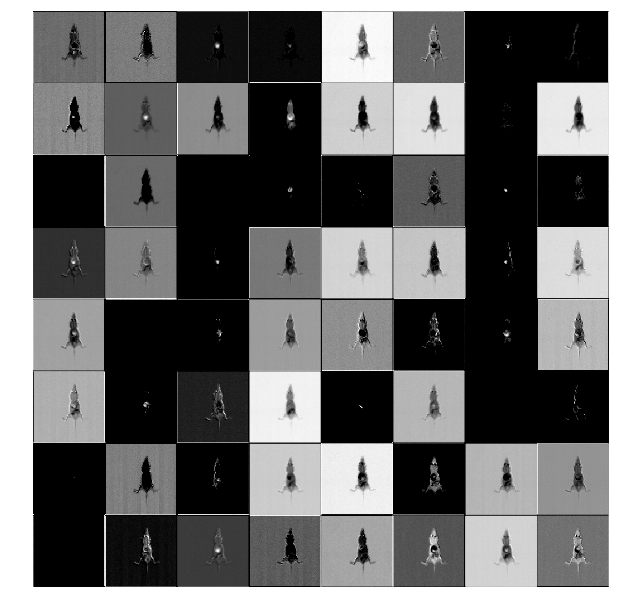

Block 3


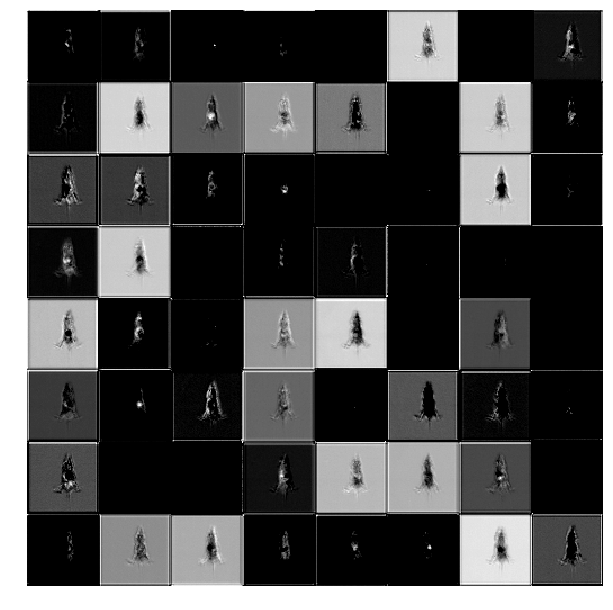

Block 4


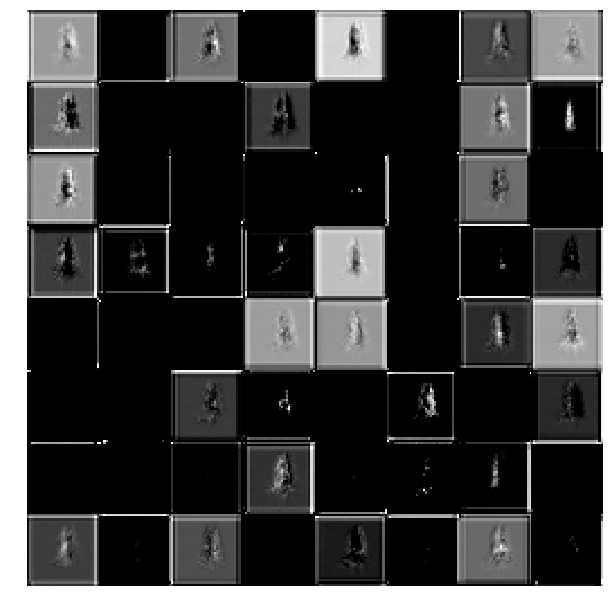

Block 5


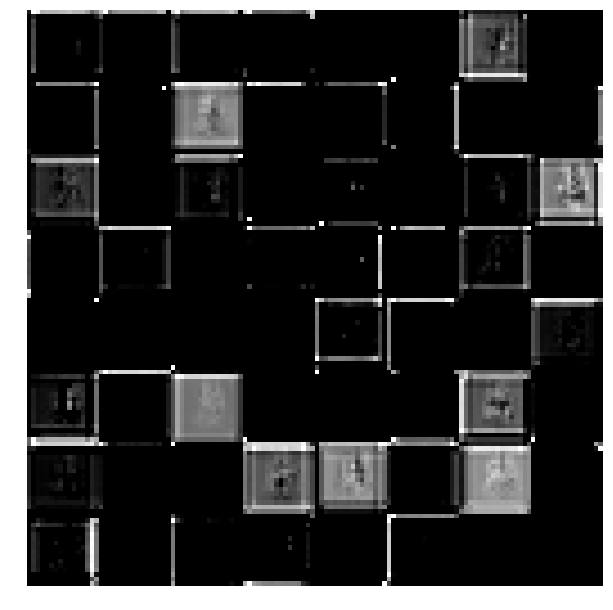

Block 6


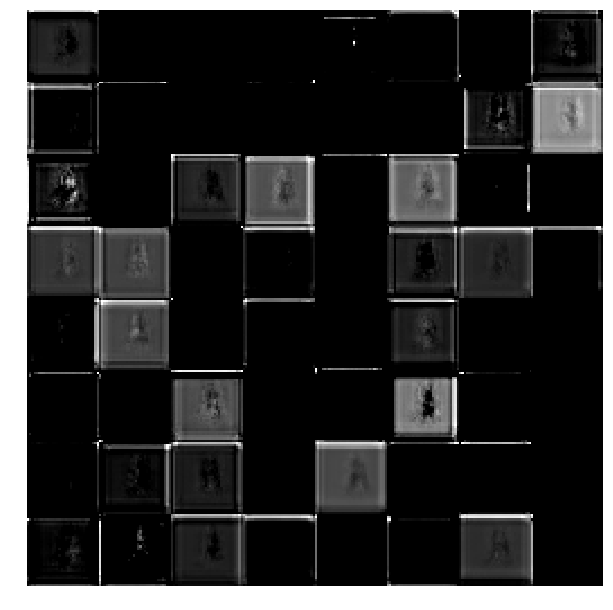

Block 7


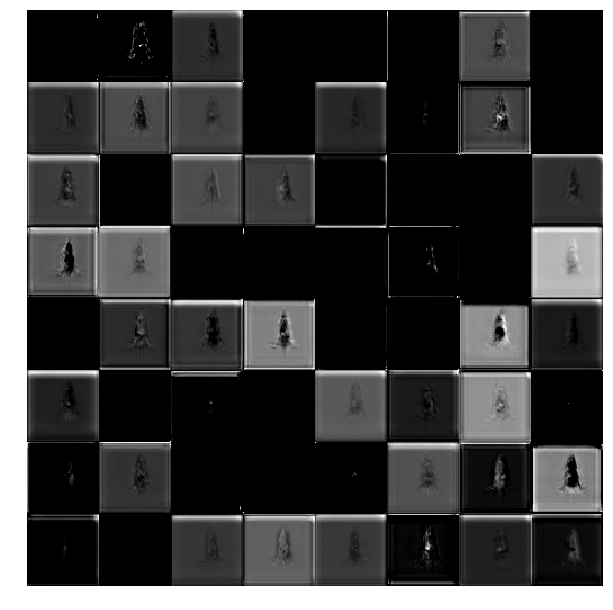

Block 8


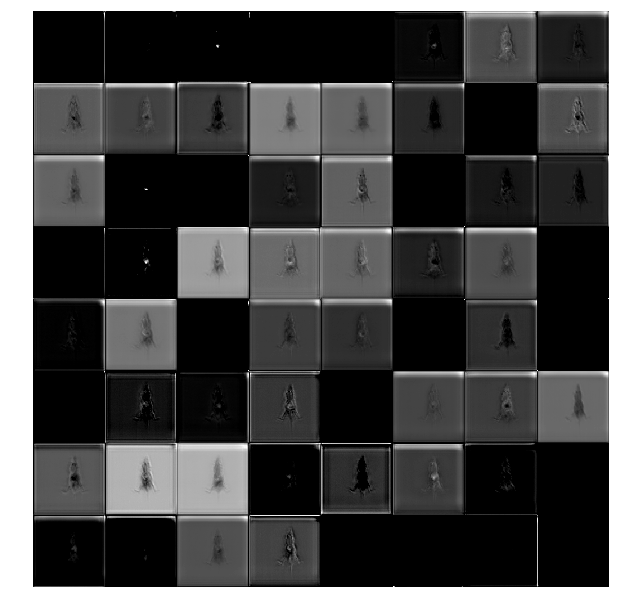

Block 9


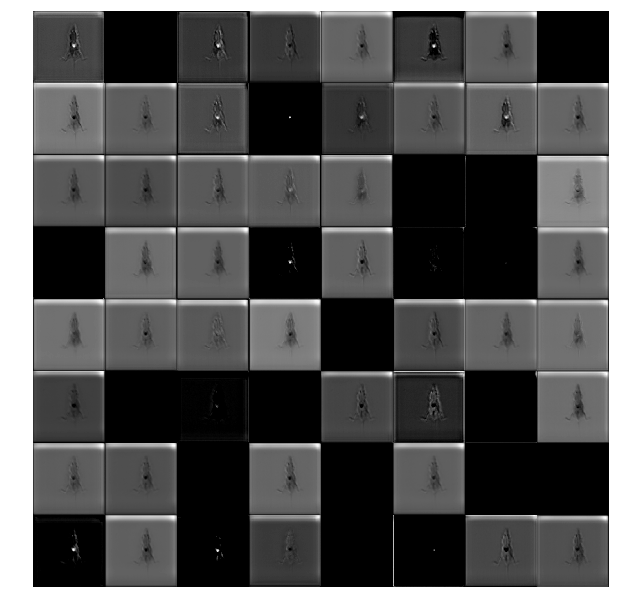

In [15]:
#pick layers at the end of each block
ixs = [2,4,8,11,15,21,26,31,36]
#model=unet()
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
model.summary()
# load the image with the required shape
img = tf.keras.preprocessing.image.load_img('test_image.png', target_size=(256, 256))
# convert the image to an array
img = tf.keras.preprocessing.image.img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = tf.keras.applications.vgg16.preprocess_input(img)

feature_maps = model.predict(img)
# plot the output from each block
square = 8

for number, fmap in enumerate(feature_maps):
    # plot all 64 maps in an 8x8 squares(some layers have more than 64 feature maps but we take samples to visualize)
    ix = 1
    print("Block " + str(number+1))
    fig = plt.figure(figsize=(square, square))
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = fig.add_subplot(square, square, ix)
            ax.axis("off")
            #print(np.shape(fmap[0,:, :, ix-1]))
            # plot filter channel in grayscale
            plt.imshow(fmap[0,:, :, ix-1], cmap='gray')
            ix += 1
   
        
    # show the figure
    fig.tight_layout()
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
    fig.savefig('block_{}.pdf'.format(number+1))
    plt.show()
    #break


In [12]:
#pick last two layers to visualize

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_49[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_50[0][0]                  
____________________________________________________________________________________________

Block 1


TypeError: unsupported operand type(s) for -: 'tuple' and 'int'

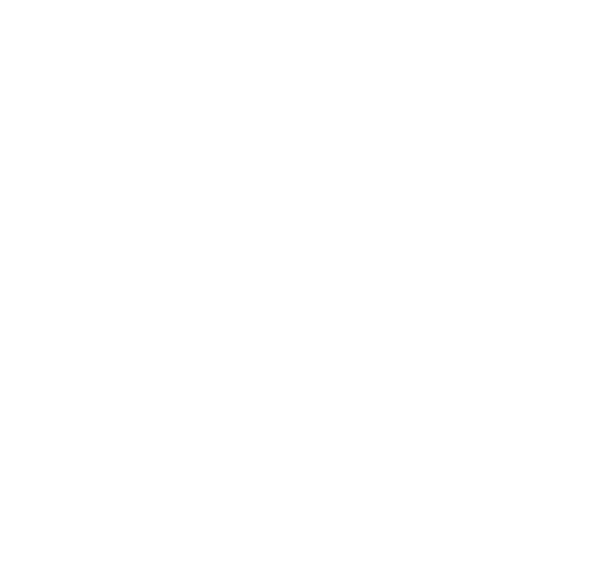

In [13]:
model = unet()
model.load_weights("unet3d.hdf5")
model.summary()
for layer in model.layers:
    weights = layer.get_weights()
    print(weights)
    break
    
#pick layers at the end of each block
ixs = [37,38]
#model=unet()
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
model.summary()

# load the image with the required shape
img = tf.keras.preprocessing.image.load_img('test_image.png', target_size=(256, 256))
# convert the image to an array
img = tf.keras.preprocessing.image.img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = tf.keras.applications.vgg16.preprocess_input(img)

feature_maps = model.predict(img)
# plot the output from each block
square = 1
fig = plt.figure(figsize=(10, 10))

for number, fmap in enumerate(feature_maps):
    # plot all 64 maps in an 8x8 squares(some layers have more than 64 feature maps but we take samples to visualize)
    ix = 1
    print("Block " + str(number+1))
    for ix in itertools.product(range(square), repeat=2):
        ax = fig.add_subplot(square, square, ix)
        ax.axis("off")
        #print(np.shape(fmap[0,:, :, ix-1]))
        # plot filter channel in grayscale
        ax.imshow(fmap[0,:, :, ix-1], cmap='gray')
    
        
    # show the figure
    
    fig.savefig('last_layers'+str(number)+'.pdf')
    plt.show()
    #break

    
